# Read and Parse Chainer logs

In [1]:
%matplotlib inline
import re
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd

In [2]:
!ls cifar*.log

cifar-series-4.log               cifar_series_25run_mose_adam.log
cifar-series.log                 cifar_series_run_25fix.log
cifar_errors.log                 cifar_series_run_DL_25fix.log


## CIFAR100 runs with various batch sizes and learning rates

In [3]:
def fileToDF(logfile):
    run_pattern = re.compile(r"^run\s+(\d+)/(\d+)")
    output_pattern = re.compile(r"^(\d+)\s+([0-9\.]+)\s+([0-9\.]+)\s+([0-9\.]+)\s+([0-9\.]+)\s+([0-9\.]+)")
    with open(logfile,"r") as f:
        lines = f.readlines()
        batch = 0
        epoch = 0
        ind = 0
        loss = 0
        acc = 0
        learn = 0
        time = 0
        df = pd.DataFrame(data=None,columns=["run","epoch","loss","acc","time"])
        for line in lines:
            s = line.strip()
            m = run_pattern.match(s)        
            if m:
                run = int(m.group(1))
    #            learn = float(m.group(2))            
    #            run += 1
                #print batch,learn
            else:
                m = output_pattern.match(s)
                if m:
                    epoch = int(m.group(1))
                    loss = float(m.group(3))
                    acc = float(m.group(5))
                    time = float(m.group(6))
                    #print batch,learn,loss,acc,time
                    df.loc[ind] = [run,epoch,loss,acc,time]
                    ind += 1
                    
    return df

In [4]:
logfiles=["cifar_series_run_25fix.log","cifar_series_run_DL_25fix.log","cifar_series_25run_mose_adam.log"]
names=["mouse-SGD","DL-SGD","Mouse-Adam"]
DF={}
for i in range(0,len(logfiles)):
    logfile = logfiles[i]
    df = fileToDF(logfile)
    DF[names[i]]=df

In [10]:
def RelativePercentDifference(ser):
    mean = ser.mean()
    ser = ser.apply(lambda x: x/mean*100)
    return ser

In [11]:
def SplitDFintoLossAccTime(df):
    df_loss = df.pivot(index="run",columns="epoch",values="loss")
    df_loss.index = df_loss.index.map(lambda s: "loss"+str(int(s)))
    df_acc = df.pivot(index="run",columns="epoch",values="acc")
    df_acc.index = df_acc.index.map(lambda s: "acc"+str(int(s)))
    df_time = df.pivot(index="run",columns="epoch",values="time")
    df_time.index = df_time.index.map(lambda s: "time"+str(int(s)))
    
#    df_time["perc"] = df_time[10]
    df_time["perc"] = RelativePercentDifference(df_time[10])
#    df_acc["perc"] = df_acc[10]
    df_acc["perc"] = RelativePercentDifference(df_acc[10])
#    df_loss["perc"] = df_loss[10]
    df_loss["perc"] = RelativePercentDifference(df_loss[10])
    return {"acc":df_acc,"loss":df_loss, "time":df_time}


In [15]:
DF3 = {}
for name,df in DF.iteritems():
    DF3[name] = SplitDFintoLossAccTime(df)

In [74]:
print DF3.keys()
print DF3['mouse-SGD'].keys()

['mouse-SGD', 'DL-SGD', 'Mouse-Adam']
['acc', 'loss', 'time']


In [71]:
# Merge same "column" from multiple dataframes, using "names" for column names 
# in te new merged dataframe.
def mergeColumnMultiDFs(DFs,names,column):
    s1 = None
    merged = None
    for i in range(0,len(DFs)):
        if column not in DFs[i].columns:
            print column,"not in",DFs[i].columns
            return None
        s2 = DFs[i][column]
        s2 = s2.rename(names[i])
        if s1 is None :
            s1 = s2
        elif merged is None:
            merged = pd.concat([s1,s2],axis=1)
        else:
            merged = pd.concat([merged,s2],axis=1)
    return merged

In [75]:
def getParameterDFs(par, DF3):
    dfs = []
    for setup in DF3.keys():
        dfs.append(DF3[setup][par])
    return dfs

In [76]:
acc_dfs = getParameterDFs("acc",DF3)
epoch10_acc = mergeColumnMultiDFs(acc_dfs,DF3.keys(),10)

In [77]:
epoch10_acc.head()

,mouse-SGD,DL-SGD,Mouse-Adam
run,,,
acc1,0.093026,0.084892,0.215091
acc2,0.102574,0.112988,0.231491
acc3,0.151494,0.110053,0.229452
acc4,0.115682,0.084622,0.209817
acc5,0.093032,0.093181,0.267084


In [12]:
def plotBox(df):
    meanlineprops = dict(linewidth=1, color=(0.2,.5,.8),linestyle="--")
    color = dict(medians=(1,.7,.3))
    df.plot.box(showmeans=True, meanline=True, 
                            color=color,meanprops=meanlineprops)
    ax = plt.gca()
    return ax

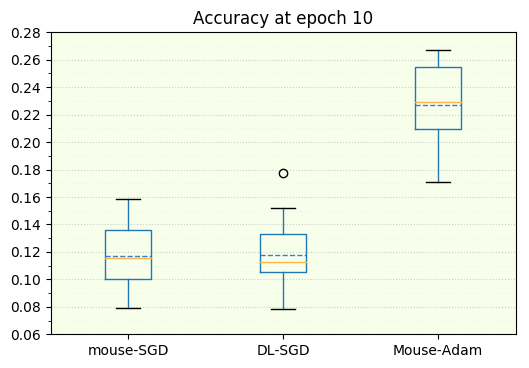

In [56]:
ax = plotBox(epoch10_acc)
ax.set_title("Accuracy at epoch 10")
major = np.arange(0.06,0.28,0.02)
ax.set_yticks(major)
ax.yaxis.grid(which="major", linestyle=":",color="#cccccc")
minor = np.arange(0.07,0.29,0.02)
ax.set_yticks(minor, minor=True)
ax.yaxis.grid(which="minor", linestyle=":",color="#cccccc",alpha=0.2)
ax.set_facecolor("#CBFF7725")

In [45]:
#acc_dfs = getParameterDFs("acc",DF3)
perc_acc = mergeColumnMultiDFs(acc_dfs,DF3.keys(),"perc")
perc_acc.head()

,mouse-SGD,DL-SGD,Mouse-Adam
run,,,
acc1,79.688740,71.963132,94.603496
acc2,87.867642,95.780173,101.816709
acc3,129.773827,93.292167,100.919896
acc4,99.096307,71.734253,92.283832
acc5,79.693623,78.989990,117.471582


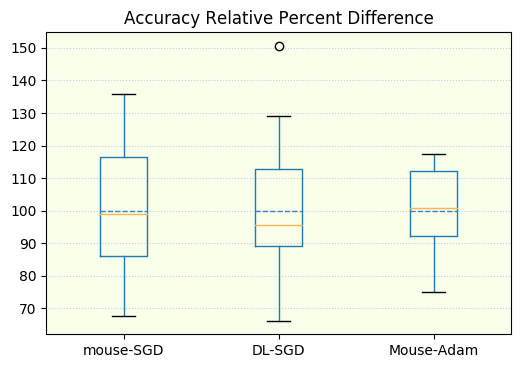

In [63]:
ax = plotBox(perc_acc)
ax.set_title("Accuracy Relative Percent Difference")
major = np.arange(70,160,10)
ax.set_yticks(major)
ax.yaxis.grid(which="major", linestyle=":",color="#cccccc")
#minor = np.arange(0.07,0.29,0.02)
#ax.set_yticks(minor, minor=True)
#ax.yaxis.grid(which="minor", linestyle=":",color="#cccccc",alpha=0.2)
ax.set_facecolor("#CBFF7725")

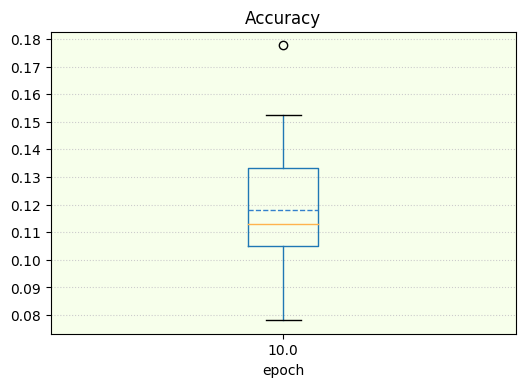

In [34]:
ax = plotBox(df_acc[10])
ax.set_title("Accuracy")
ax.yaxis.grid(linestyle=":",color="#cccccc")
ax.set_xlabel("epoch")
major = np.arange(0.08,0.19,0.01)
ax.set_yticks(major)
ax.set_facecolor("#CBFF7725")



In [78]:
loss_dfs = getParameterDFs("loss",DF3)
epoch10_loss = mergeColumnMultiDFs(loss_dfs,DF3.keys(),10)

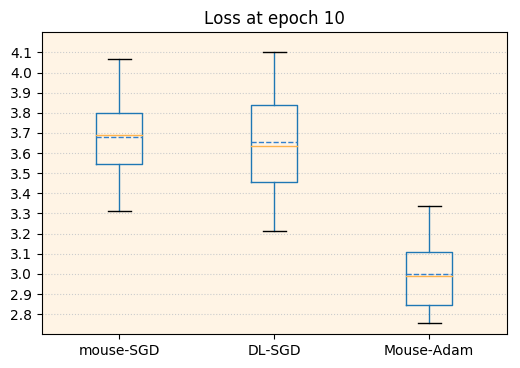

In [99]:
ax = plotBox(epoch10_loss)
ax.set_title("Loss at epoch 10")
ax.yaxis.grid(linestyle=":",color="#cccccc")
major = np.arange(2.8,4.11,.1)
ax.set_yticks(major)
ax.set_ylim([2.7,4.2])
ax.set_facecolor("#FFAC3620")

In [88]:
perc_loss = mergeColumnMultiDFs(loss_dfs,DF3.keys(),"perc")

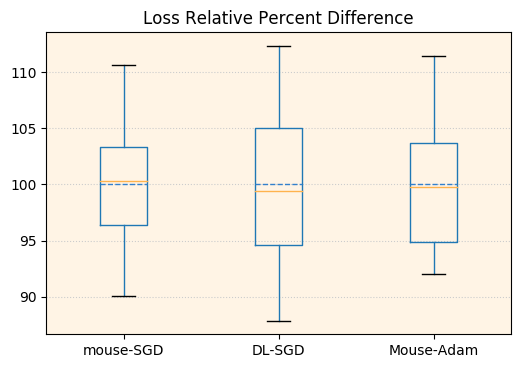

In [93]:
ax = plotBox(perc_loss)
ax.set_title("Loss Relative Percent Difference")
ax.yaxis.grid(linestyle=":",color="#cccccc")
major = np.arange(90,115,5)
ax.set_yticks(major)
# ax.set_ylim([2.7,4.2])
ax.set_facecolor("#FFAC3620")

In [100]:
time_dfs = getParameterDFs("time",DF3)
epoch10_time = mergeColumnMultiDFs(time_dfs,DF3.keys(),10)

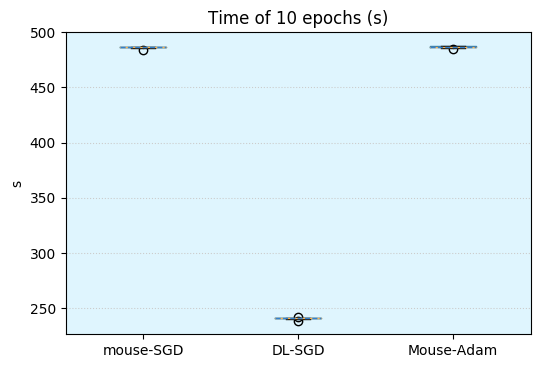

In [106]:
ax = plotBox(epoch10_time)
ax.set_title("Time of 10 epochs (s)")
ax.yaxis.grid(linestyle=":",color="#cccccc")
ax.set_ylabel("s")
# major = np.arange(2.8,4.11,.1)
# ax.set_yticks(major)
# ax.set_ylim([2.7,4.2])
ax.set_facecolor("#00B7FA20")

In [103]:
perc_time = mergeColumnMultiDFs(time_dfs,DF3.keys(),"perc")

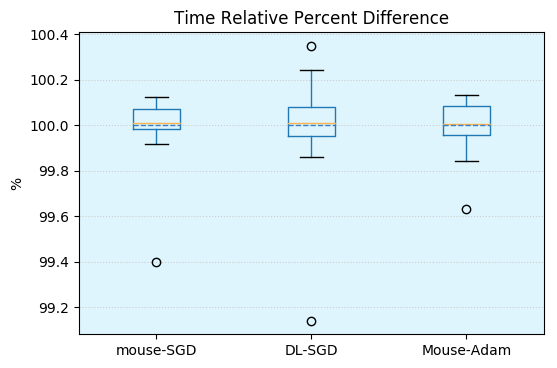

In [104]:
ax = plotBox(perc_time)
ax.yaxis.grid(linestyle=":",color="#cccccc")
ax.set_ylabel("%")
ax.set_title("Time Relative Percent Difference")
#major = np.arange(99.2,100.5,0.1)
#ax.set_yticks(major)
ax.set_facecolor("#00B7FA20")